<a href="https://colab.research.google.com/github/ericodle/uddf_analytics/blob/main/UDDF_3Dtraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dive computers store data in standard UDDF (Universal Dive Data Format)...format. 
If you open one of these files in a text editor, you get a block of text with various tags and values. To make sense of this infomation, we must first parse it.
The base standard is XML (eXtensible Markup Language), which Python conveniently has a built-in library to read.

In [112]:
# Original UDDF fule transferred from my ATMOS dive computer. 
# Upload from local machine to colab notebook. 
# https://github.com/ericodle/uddf_analytics/blob/main/example.uddf
# Note: the directly downloaded file doesn't seem to work with the parser.

divelog = "/content/example.uddf"

In [113]:
# This is the Python parser we will use.
import xml.etree.ElementTree as ET

tree = ET.parse(divelog)
root = tree.getroot()

print("Root Tag:")
print(root.tag)

print("Root Attribute:")
print(root.attrib)

Root Tag:
uddf
Root Attribute:
{'version': '3.2.3'}


UDDF format gives us a bunch of details for our dive, depending on whether or not the dive computer is set up to log it. For this project, we care about the ***divetime***, ***depth***, and ***heading*** tags.

The dive was 54 min 19 sec, which works out to 3259 seconds. With a start time of 0 and values apparently logged every 3 seconds, a final divetime value of 3255 passes the common sense test. 

We can look at the same data but for depth (unit = meters), and note an error of +/- 0.2 meters. This was also the discrepency between the Atmos and my Suunto, and I assume it is within sensor tolerance.

Let's store time, depth, and heading as their own variables.

In [124]:
dive_time = []
for divetime in root.iter('divetime'):
    dive_time.append(divetime.text)

dive_depth = []
for depth in root.iter('depth'):
    dive_depth.append(depth.text)

dive_heading = []
for heading in root.iter('heading'):
    dive_heading.append(heading.text)

Quick common sense check: all three lists should be the same length, given our assumption that the data will be paired and sequential for our rudimentary trajectory calculation. I found that the heading class is sometimes 2 values less than the others. This can cause an out-of-range index error later. As a workaround, you can duplcate the last heading and append it to the variable as needed.

In [130]:
dive_heading.append(dive_heading[1083])

In [132]:
dive_heading.append(dive_heading[1084])

In [134]:
print(len(dive_time))
print(len(dive_depth))
print(len(dive_heading))

1086
1086
1086


We almost have all the pieces necessary to construct a 3D trajectory. Since the accelerometer data was not included in the dive log file, we need to make a few unrealistic but model-simplifying assumptions.

First, we assume that from the start of the dive to the end of the dive, the diver was moving at a constant rate in an orientation perfectly normal to the center of the earth.

Second, we assume no current.

Third, as stated previously, we assume the compass reflects the true diver heading.

Under these assumptions, we can construct a step-wise trajectory in 3D space. 
I want to try a connect-the-dots approach. Given a known heading and speed, we can calculate XYZ positions at each time step. How about....each step is a 4-element tuple (t,x,y,z) and the whole route is a list? 

In [135]:
import numpy as np
import math

# Trigonometry experts, please check my logic.

def pol2cart_x(diverSpeed, phi):
    x = float(diverSpeed) * np.cos(math.radians(float(phi)))
    return(x)

def pol2cart_y(diverSpeed, phi):
    y = float(diverSpeed) * np.sin(math.radians(float(phi)))
    return(y)

The above functions will calculate X and Y movement at each step based on a known diver swim speed and heading angle (taken from wrist computer compass in this example).

In [136]:
route = []

diver_speed = 1 # Arbitrary unitless value for easy polar -> cartesian conversion

# x and y are going to change with each iteration of the FOR loop,
# so we need to keep track of them.
x = 0 # x-axis is taken as the North-South axis
y = 0 # y-axis is taken as the East-West axis

for i in range(0,len(dive_time)):
  t = dive_time[i]
  x += pol2cart_x(diver_speed, dive_heading[i])
  y += pol2cart_y(diver_speed, dive_heading[i])
  z = float(dive_depth[i]) * (-1) # z-axis is taken as depth.

  route.append((t, x, y, z))

We now have X's, Y's, and Z's. Let's plot them. 
Pandas dataframes are more familiar to me here.

In [137]:
import pandas as pd
df = pd.DataFrame(route, columns =['time', 'x', 'y', 'z'], dtype = float)

Check the DataFrame.

In [138]:
df

,time,x,y,z
0,0.0,-0.258819,0.965926,-2.625
1,3.0,-0.311155,1.964555,-2.675
2,6.0,0.142835,2.855562,-2.675
3,9.0,-0.401804,3.694232,-2.965
4,12.0,-0.366904,4.693623,-3.265
...,...,...,...,...
1081,3243.0,-98.242219,-69.864725,0.205
1082,3246.0,-99.071257,-69.305532,0.215
1083,3249.0,-99.890409,-69.879109,0.225
1084,3252.0,-100.709561,-70.452685,0.195


Finally, we can use MatPlotLib's 3D graphing function to plot our points. Given Colab's zoomed-out, tiny window, the points will be so close together that they will form the appearance of a solid line. Otherwise we could trace a line through the points.

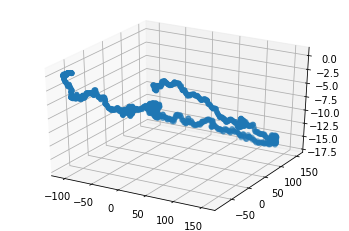

In [140]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df["x"], df["y"], df["z"])

The route goes down, then comes up, following roughly the same path out and in. You can see the start and end points are far apart, which is what we did at Bat Cave (northern Taiwan) during our annual underwater beach cleanup when the data was logged. 

Getting interactive MatPlotLib graphs to work in Google Colab is tricky. If you run this on your local computer you can probably rotate the trajectory in 3D.

Dive computers provide a wealth of data for divers to analyze independently. 